# 프로젝트: CutMix 또는 Mixup 비교실험 하기

## ✅ 실습목표

------------------

* Augmentation을 모델 학습에 적용하기
* Augmentation의 적용을 통한 학습 효과 확인하기
* 최신 data augmentation 기법 구현 및 활용하기

## ✅ 목차 

---------------------

**1.** 데이터 불러오기       

**2.** Augmentation 적용하기           

**3.** Cutmix Augmentation           

**4.** Mixup Augmentation       

**5.** 데이터셋 제작

**6.** 모델 만들기    

**7.** 모델훈련하기    

**8.** 시각화 하기     

**9.** Augmentation에 의한 모델 성능 비교

## 1. 데이터 불러오기

In [1]:
# 먼저 필요한 라이브러리들을 불러오겠습니다!
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

***GPU***환경을 확인해보도록 하겠습니다.

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

#### [stanford_dogs](https://www.tensorflow.org/datasets/catalog/stanford_dogs)을 사용하겠습니다.
* 120개 견종의 이미지포함
* 총 20,580장의 이미지에서 12,000장은 학습셋, 나머지 8,580장은 평가용 데이터셋

In [3]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)

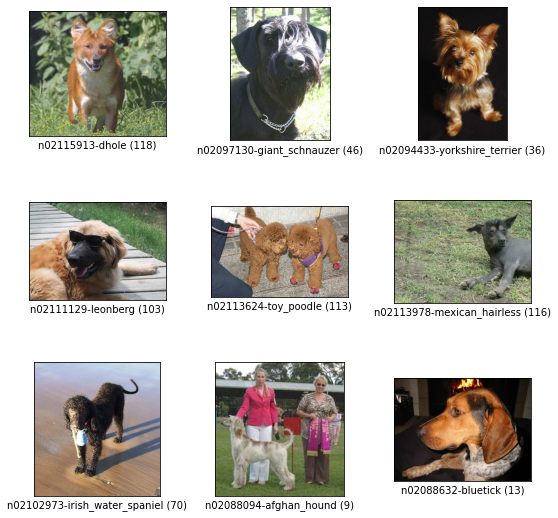

In [4]:
fig = tfds.show_examples(ds_train, ds_info)

## 2. Augmentation 적용하기

--------

텐서플로우 Random Augmentation API 사용하기    

이미지셋에 대해서 랜덤한 확률로 바로 적용할 수 있는 augmentation 함수들은 아래와 같습니다.

* random_brightness()
* random_contrast()
* random_crop()
* random_flip_left_right()
* random_flip_up_down()
* random_hue()
* random_jpeg_quality()
* random_saturation()

In [5]:
# 기본적인 전처리 함수.
# 0~1사이의 float32로 normalize하고 (224,224)사이즈로 resize
def normalize_and_resize_img(image, label):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

In [8]:
def augment(image, label):
    # 이미지를 좌우로 무작위로 뒤집습니다 (왼쪽에서 오른쪽으로).
    image = tf.image.random_contrast(image, 0.2, 0.5)
    image = tf.image.random_saturation(image, 5, 15)
    image = tf.image.random_hue(image, max_delta=0.2)
    image = tf.image.random_jpeg_quality(image, 75, 95)
    image = tf.clip_by_value(image, 0, 1)
    return image, label

In [9]:
# 데이터셋(ds)을 가공하는 메인함수
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False):
    ds = ds.map(
        normalize_and_resize_img,  # 기본적인 전처리 함수 적용
        num_parallel_calls=2
    )
    # with_aug 매개변수를 사용해서 augmentation의 적용여부를 결정할 수 있도록 함
    if not is_test and with_aug:
        ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [10]:
ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False)

In [11]:
num_classes = ds_info.features["label"].num_classes

## 3. Cutmix Augmentation

--------------

조금 더 복잡한 augmentation 방법을 알아보겠습니다.

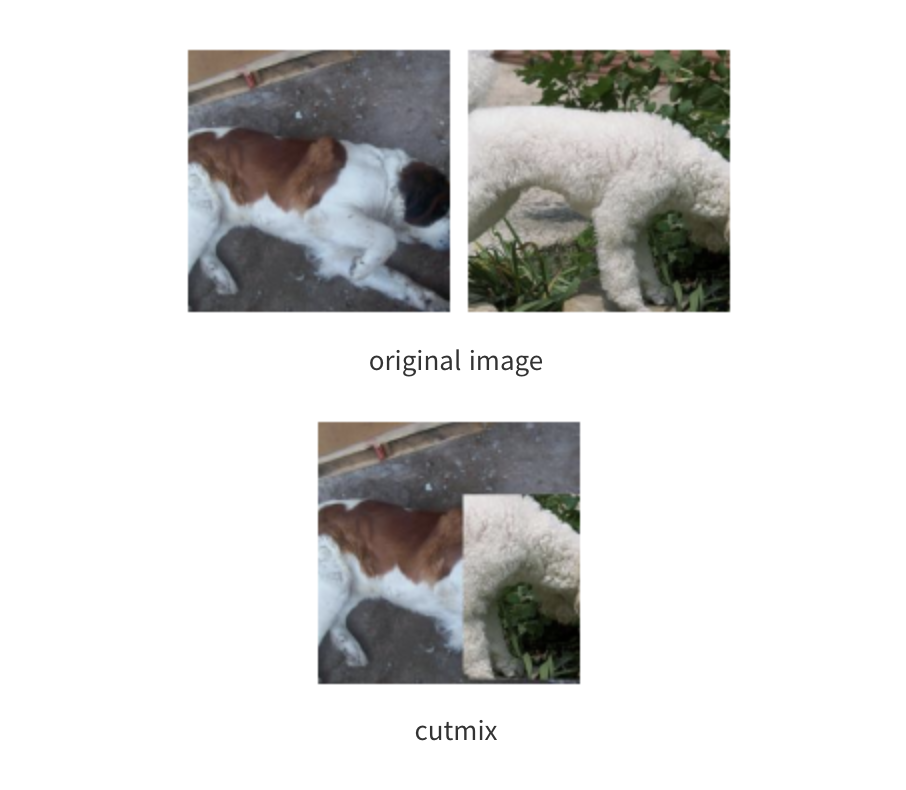

* #### 이름인 CutMix를 보고 유추할 수 있듯 이미지 데이터를 자르고 섞는다고 생각할 수 있습니다.
* #### CutMix는 모델이 객체의 차이를 식별할 수 있는 부분에 집중하지 않고, 덜 구별되는 부분 및 이미지의 전체적인 구역을 보고 학습도록 하여 일반화와 localization 성능을 높이는 방법입니다.

### 3-1) 이미지 섞기

-------------------------

* 먼저 두 개의 이미지를 섞어주는 것부터 생각을 해보겠습니다.
* 배치 내의 이미지를 두 개 골라서 섞어주는데, 이때 이미지에서 잘라서 섞어주는 영역을 **바운딩 박스(bounding box)** 라고 부릅니다.

In [12]:
import matplotlib.pyplot as plt

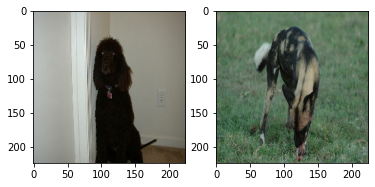

In [13]:
# 데이터셋에서 이미지 2개를 가져옵니다. 
for i, (image, label) in enumerate(ds_train_no_aug.take(1)):
    if i == 0:
        image_a = image[0]
        image_b = image[1]
        label_a = label[0]
        label_b = label[1]
        break

plt.subplot(1,2,1)
plt.imshow(image_a)

plt.subplot(1,2,2)
plt.imshow(image_b)

plt.show()

In [14]:
# 첫 번째 이미지(a)를 배경 이미지로 하고 거기에 삽입할 두 번째 이미지(b)가 있을 때 
# 첫 번째 영역의 바운딩 박스의 위치를 결정하는 함수를 먼저 구현해보도록 하겠습니다.
# 임의의 이미지 사이즈에 대해서도 유연하게 대응 가능하도록 구현
def get_clip_box(image_a, image_b):
    # image.shape = (height, width, channel)
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    
    # get center of box
    # tf.cast : 텐서를 새로운 형태로 캐스팅하는데 사용
    x = tf.cast(tf.random.uniform([], 0, image_size_x), tf.int32)
    y = tf.cast(tf.random.uniform([], 0, image_size_y), tf.int32)

    # get width, height of box
    # tf.math.sqrt : 제곱근을 계산
    width = tf.cast(image_size_x*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    height = tf.cast(image_size_y*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    
    # clip box in image and get minmax bbox
    x_min = tf.math.maximum(0, x-width//2)
    y_min = tf.math.maximum(0, y-height//2)
    x_max = tf.math.minimum(image_size_x, x+width//2)
    y_max = tf.math.minimum(image_size_y, y+width//2)
    
    return x_min, y_min, x_max, y_max

x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)

print('x : ', x_min, x_max)
print('y : ', y_min, y_max)

x :  tf.Tensor(12, shape=(), dtype=int32) tf.Tensor(176, shape=(), dtype=int32)
y :  tf.Tensor(76, shape=(), dtype=int32) tf.Tensor(224, shape=(), dtype=int32)


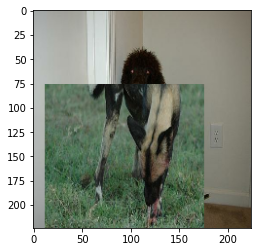

In [44]:
# 바탕이미지 image_a에서 바운딩 박스 바깥쪽 영역을, 
# 다른 이미지 image_b에서 바운딩 박스 안쪽 영역을 가져와서 합치는 함수
# mix two images
def mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    middle_left = image_a[y_min:y_max, 0:x_min, :] # image_b의 왼쪽 바깥 영역
    middle_center = image_b[y_min:y_max, x_min:x_max, :]  # image_b의 안쪽 영역
    middle_right = image_a[y_min:y_max, x_max:image_size_x, :] # image_b의 오른쪽 바깥 영역
    middle = tf.concat([middle_left,middle_center,middle_right], axis=1)
    top = image_a[0:y_min, :, :]
    bottom = image_a[y_max:image_size_y, :, :]
    mixed_img = tf.concat([top, middle, bottom],axis=0)
    
    return mixed_img

mixed_img = mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max)
plt.imshow(mixed_img.numpy())
plt.show()

###  3-2) 라벨 섞기

-------------------

이미지를 섞었으니 라벨도 이에 맞게 섞어주어야 겠죠?      

* CutMix에서는 면적에 비례해서 라벨을 섞어줍니다. 
* 섞인 이미지의 전체 이미지 대비 비율을 계산해서 두 가지 라벨의 비율로 더해줍니다.     

      ex) A 클래스를 가진 원래 이미지 image_a와 B 클래스를 가진 이미지 image_b를 섞을 때 image_a를 0.4만큼 섞었을 경우, 0.4만큼의 클래스 A, 0.6만큼의 클래스 B를 가지도록 해주기    
* 라벨벡터 - 클래스 1개만 1의 값을 가지는 원-핫 인코딩이 아니라 A와 B 클래스에 해당하는 인덱스에 각각 0.4, 0.6을 배분하는 방식을 사용!!      

In [45]:
# 섞인 이미지 두 가지에 대하여 라벨을 만들 때 적절한 비율로 라벨을 합쳐주는 함수
def mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max, num_classes=120):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    mixed_area = (x_max-x_min)*(y_max-y_min)
    total_area = image_size_x*image_size_y
    ratio = tf.cast(mixed_area/total_area, tf.float32)

    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1-ratio)*label_a + ratio*label_b
    return mixed_label

mixed_label = mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max)
mixed_label

<tf.Tensor: shape=(120,), dtype=float32, numpy=
array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.51626

In [46]:
def cutmix(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max))
        mixed_labels.append(mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

## 4. Mixup Augmentation

------------------------------------

Mixup은 앞에서 보여드린 CutMix보다 간단하게 이미지와 라벨을 섞어줍니다.     
두 개 이미지의 픽셀별 값을 비율에 따라 섞어주는 방식으로 CutMix보다 구현이 간단하다고 볼 수 있습니다.

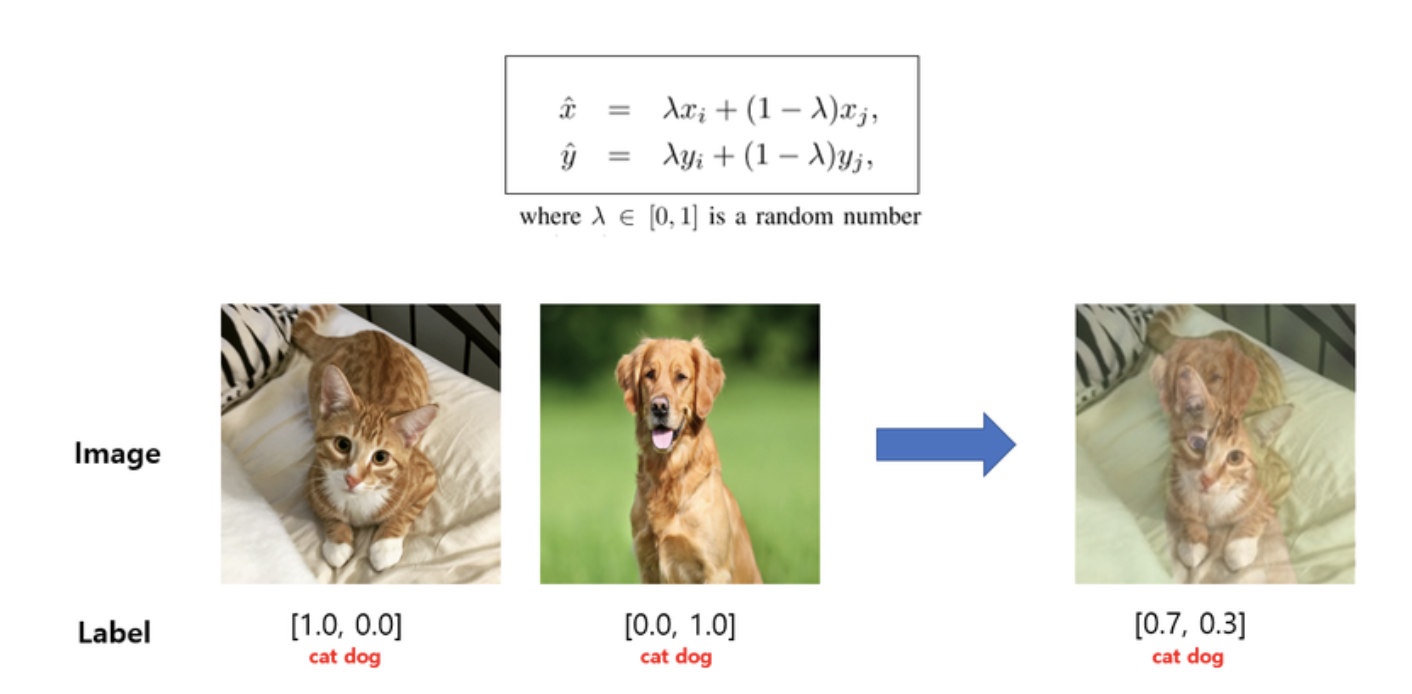

In [47]:
num_classes = ds_info.features["label"].num_classes
num_classes

120

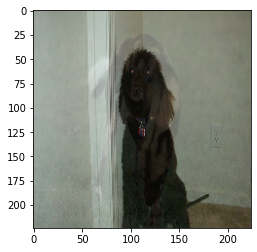

tf.Tensor(
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.76545167 0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         

In [48]:
# function for mixup
def mixup_2_images(image_a, image_b, label_a, label_b):
    ratio = tf.random.uniform([], 0, 1)
    
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_image= (1-ratio)*image_a + ratio*image_b
    mixed_label = (1-ratio)*label_a + ratio*label_b
    
    return mixed_image, mixed_label

mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
plt.imshow(mixed_img.numpy())
plt.show()
print(mixed_label)

In [21]:
def mixup(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0,batch_size), tf.int32)
        image_b = image[j]
        label_b = label[j]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

## 5.  데이터셋 제작

In [22]:
def onehot(image, label) :
    label = tf.one_hot(label, num_classes)
    return image, label

In [23]:
def normalize_and_resize_img(image, label):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.clip_by_value(image, 0, 1)
    return image, label

#배치 단위로 데이터셋을 정렬 후 CutMix와 Mixup을 적용할 수 있도록 수정한 함수
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False, with_cutmix=False, with_mixup=False):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment
        )
    ds = ds.batch(batch_size)
    if not is_test and with_cutmix:
        ds = ds.map(
            cutmix,
            num_parallel_calls=2
        )
    else:
        ds = ds.map(
            onehot,
            num_parallel_calls=2
        )
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [24]:
# augmentation이 적용된 데이터셋과 적용되지 않은 데이터셋 생성
ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False)
ds_train_aug = apply_normalize_on_dataset(ds_train, with_aug=True)
ds_train_cutmix = apply_normalize_on_dataset(ds_train, with_cutmix=True)
ds_train_mixup = apply_normalize_on_dataset(ds_train, with_mixup=True)
ds_test = apply_normalize_on_dataset(ds_test, is_test = True)

## 6. 모델 만들기

### 6-1) No Augmentation

In [25]:
# imagenet 데이터에 훈련된 ResNet50 모델 불러오기
no_aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False, # 마지막 fully connected layer 미포함
        weights='imagenet',
        input_shape=(224, 224, 3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')  # 데이터에 맞는 FC layer 붙여서 활용
])

94773248/94765736 [==============================] - 1s 0us/step


### 6-2) 기본 Augmentation

In [26]:
# Augmentation을 적용한 데이터셋으로 학습시킬 ResNet 생성
aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224, 3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

### 6-3) Cutmix Augmentation

In [27]:
cutmix_aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224, 3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

### 4) Mixup Augmentation

In [28]:
mixup_aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224, 3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

## 7. 모델훈련하기

--------------------------

cutmix(), mixup()을 구현하면서 label의 mix 때문에 더이상 label이 스칼라값을 가지지 못하고 One-Hot 벡터 형태로 변환되었기 때문에    

sparse_categorical_crossentropy()대신에 categorical_crossentropy()를 사용하도록 하겠습니다.

In [29]:
EPOCH = 20
tf.random.set_seed(2705)

no_aug_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

aug_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

cutmix_aug_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

mixup_aug_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

In [30]:
his_no_aug_resnet50 = no_aug_resnet50.fit(
    ds_train_no_aug, # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 352s 433ms/step - loss: 3.1514 - accuracy: 0.2839 - val_loss: 3.4611 - val_accuracy: 0.1975
Epoch 2/20
750/750 [==============================] - 325s 434ms/step - loss: 0.9262 - accuracy: 0.7403 - val_loss: 1.0915 - val_accuracy: 0.6785
Epoch 3/20
750/750 [==============================] - 325s 433ms/step - loss: 0.2954 - accuracy: 0.9340 - val_loss: 0.9583 - val_accuracy: 0.7181
Epoch 4/20
750/750 [==============================] - 325s 433ms/step - loss: 0.0780 - accuracy: 0.9910 - val_loss: 0.9055 - val_accuracy: 0.7428
Epoch 5/20
750/750 [==============================] - 325s 433ms/step - loss: 0.0332 - accuracy: 0.9975 - val_loss: 0.9116 - val_accuracy: 0.7455
Epoch 6/20
750/750 [==============================] - 325s 433ms/step - loss: 0.0170 - accuracy: 0.9997 - val_loss: 0.9474 - val_accuracy: 0.7399
Epoch 7/20
750/750 [==============================] - 325s 434ms/step - loss: 0.0292 - accuracy: 0.9977 - val_loss: 0.9888 -

In [32]:
his_aug_resnet50 = aug_resnet50.fit(
    ds_train_no_aug, 
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 326s 433ms/step - loss: 0.0378 - accuracy: 0.9981 - val_loss: 0.8976 - val_accuracy: 0.7407
Epoch 2/20
750/750 [==============================] - 325s 433ms/step - loss: 0.0225 - accuracy: 0.9987 - val_loss: 0.9060 - val_accuracy: 0.7425
Epoch 3/20
750/750 [==============================] - 325s 433ms/step - loss: 0.0139 - accuracy: 0.9997 - val_loss: 0.9437 - val_accuracy: 0.7406
Epoch 4/20
750/750 [==============================] - 325s 433ms/step - loss: 0.0105 - accuracy: 1.0000 - val_loss: 0.9292 - val_accuracy: 0.7428
Epoch 5/20
750/750 [==============================] - 325s 433ms/step - loss: 0.0094 - accuracy: 0.9997 - val_loss: 0.9611 - val_accuracy: 0.7383
Epoch 6/20
750/750 [==============================] - 325s 433ms/step - loss: 0.0075 - accuracy: 0.9998 - val_loss: 0.9522 - val_accuracy: 0.7409
Epoch 7/20
750/750 [==============================] - 325s 433ms/step - loss: 0.0065 - accuracy: 0.9999 - val_loss: 0.9770 -

In [33]:
his_cutmix_aug_resnet50 = cutmix_aug_resnet50.fit(
    ds_train_no_aug, 
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 331s 434ms/step - loss: 3.1582 - accuracy: 0.2816 - val_loss: 3.2184 - val_accuracy: 0.2320
Epoch 2/20
750/750 [==============================] - 325s 433ms/step - loss: 0.9520 - accuracy: 0.7343 - val_loss: 1.2348 - val_accuracy: 0.6468
Epoch 3/20
750/750 [==============================] - 325s 433ms/step - loss: 0.3778 - accuracy: 0.9085 - val_loss: 0.9829 - val_accuracy: 0.7112
Epoch 4/20
750/750 [==============================] - 325s 433ms/step - loss: 0.0998 - accuracy: 0.9878 - val_loss: 0.9103 - val_accuracy: 0.7390
Epoch 5/20
750/750 [==============================] - 325s 433ms/step - loss: 0.0308 - accuracy: 0.9988 - val_loss: 0.9157 - val_accuracy: 0.7393
Epoch 6/20
750/750 [==============================] - 325s 433ms/step - loss: 0.0165 - accuracy: 0.9997 - val_loss: 0.9268 - val_accuracy: 0.7394
Epoch 7/20
750/750 [==============================] - 325s 433ms/step - loss: 0.0123 - accuracy: 0.9996 - val_loss: 0.9452 -

In [34]:
his_mixup_aug_resnet50 = mixup_aug_resnet50.fit(
    ds_train_no_aug, 
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 330s 433ms/step - loss: 3.1829 - accuracy: 0.2823 - val_loss: 3.7491 - val_accuracy: 0.1679
Epoch 2/20
750/750 [==============================] - 325s 433ms/step - loss: 0.9328 - accuracy: 0.7390 - val_loss: 1.1944 - val_accuracy: 0.6552
Epoch 3/20
750/750 [==============================] - 325s 433ms/step - loss: 0.2844 - accuracy: 0.9348 - val_loss: 0.9764 - val_accuracy: 0.7160
Epoch 4/20
750/750 [==============================] - 325s 433ms/step - loss: 0.0762 - accuracy: 0.9924 - val_loss: 0.9397 - val_accuracy: 0.7281
Epoch 5/20
750/750 [==============================] - 325s 434ms/step - loss: 0.0583 - accuracy: 0.9955 - val_loss: 0.9302 - val_accuracy: 0.7364
Epoch 6/20
750/750 [==============================] - 325s 434ms/step - loss: 0.0231 - accuracy: 0.9992 - val_loss: 0.9115 - val_accuracy: 0.7429
Epoch 7/20
750/750 [==============================] - 325s 433ms/step - loss: 0.0125 - accuracy: 0.9995 - val_loss: 0.9286 -

## 8. 시각화 하기

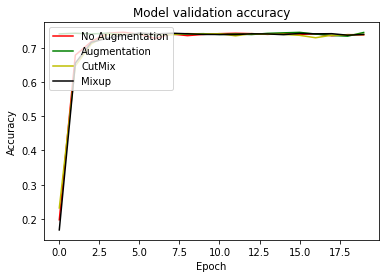

In [49]:
plt.plot(his_no_aug_resnet50.history['val_accuracy'], 'r')
plt.plot(his_aug_resnet50.history['val_accuracy'], 'g')
plt.plot(his_cutmix_aug_resnet50.history['val_accuracy'], 'y')
plt.plot(his_mixup_aug_resnet50.history['val_accuracy'], 'k')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'Augmentation', 'CutMix', 'Mixup'], loc='upper left')
plt.show()

조금 더 확대해서 보겠습니다

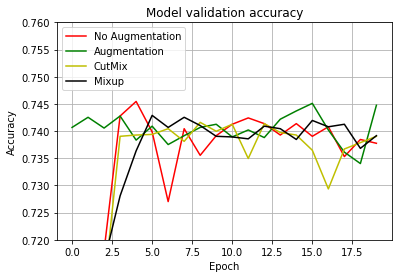

In [57]:
plt.plot(his_no_aug_resnet50.history['val_accuracy'], 'r')
plt.plot(his_aug_resnet50.history['val_accuracy'], 'g')
plt.plot(his_cutmix_aug_resnet50.history['val_accuracy'], 'y')
plt.plot(his_mixup_aug_resnet50.history['val_accuracy'], 'k')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'Augmentation', 'CutMix', 'Mixup'], loc='upper left')
plt.grid(True)
plt.ylim(0.72, 0.76) 
plt.show()

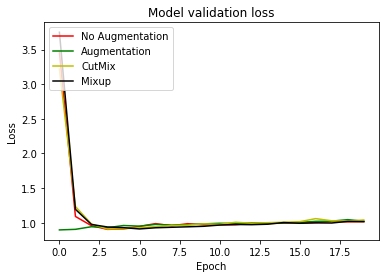

In [64]:
plt.plot(his_no_aug_resnet50.history['val_loss'], 'r')
plt.plot(his_aug_resnet50.history['val_loss'], 'g')
plt.plot(his_cutmix_aug_resnet50.history['val_loss'], 'y')
plt.plot(his_mixup_aug_resnet50.history['val_loss'], 'k')
plt.title('Model validation loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'Augmentation', 'CutMix', 'Mixup'], loc='upper left')
plt.show()

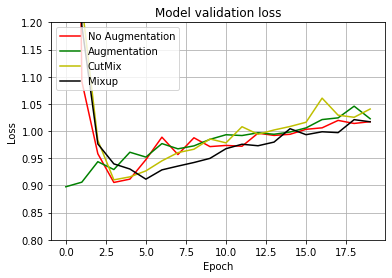

In [72]:
plt.plot(his_no_aug_resnet50.history['val_loss'], 'r')
plt.plot(his_aug_resnet50.history['val_loss'], 'g')
plt.plot(his_cutmix_aug_resnet50.history['val_loss'], 'y')
plt.plot(his_mixup_aug_resnet50.history['val_loss'], 'k')
plt.title('Model validation loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'Augmentation', 'CutMix', 'Mixup'], loc='upper left')
plt.grid(True)
plt.ylim(0.8, 1.2) 
plt.show()

## 9. Augmentation에 의한 모델 성능 비교

In [39]:
import pandas as pd

In [40]:
acc_data = {'No Augmentation': his_no_aug_resnet50.history['val_accuracy'], 
            'Augmentation': his_aug_resnet50.history['val_accuracy'], 
            'CutMix': his_cutmix_aug_resnet50.history['val_accuracy'], 
            'Mixup': his_mixup_aug_resnet50.history['val_accuracy']}
acc_df = pd.DataFrame(acc_data)
acc_df

,No Augmentation,Augmentation,CutMix,Mixup
0,0.197528,0.740672,0.232043,0.167910
1,0.678521,0.742537,0.646805,0.655201
2,0.718050,0.740555,0.711171,0.715952
3,0.742770,0.742770,0.739039,0.728078
4,0.745452,0.738340,0.739272,0.736357
5,0.739855,0.740905,0.739389,0.742887
6,0.727029,0.737523,0.740438,0.740672
7,0.740438,0.739156,0.738106,0.742537
8,0.735541,0.740672,0.741605,0.741021
9,0.739156,0.741255,0.739972,0.739039


In [42]:
acc_df.describe()

,No Augmentation,Augmentation,CutMix,Mixup
count,20.000000,20.000000,20.000000,20.000000
mean,0.708069,0.740421,0.707195,0.705346
std,0.121051,0.002756,0.113831,0.127987
min,0.197528,0.734025,0.232043,0.167910
25%,0.735483,0.738893,0.736095,0.736707
50%,0.739214,0.740613,0.739039,0.739097
75%,0.741284,0.742275,0.739797,0.740934
max,0.745452,0.745103,0.741605,0.742887


|비교|내용|
|:--------------------|:---------|
|Augmentation vs CutMix	vs Mixup| 엄청 큰 차이는 아니지만 CutMix, Mixup보다 Augmentation적용모델이 accuracy나 다른 성능이 좋게 나왔습니다.   CutMix, Mixup을 적용했을 때 성능이 차이가 나게 좋게 나오지 않았습니다.|
|No Augmentation vs Augmentation| 둘다 비슷한 accuracy를 가지지만 Augmentation이 조금 더 높게 나왔습니다.|      


# 🌟 루브릭

|평가문항|상세기준|
|:----------|:-------------|
|1. CutMix와 MixUp 기법을 ResNet50 분류기에 성공적으로 적용하였는가?|CutMix와 MixUp을 적용한 데이터셋으로 훈련한 각각의 ResNet 모델이 수렴하였다.|
|2. 다양한 실험을 통해 태스크에 최적인 Augmentation 기법을 찾아내었는가?|Augmentation 적용을 통해 Augmentaion 미적용시 대비 5% 이상의 성능향상을 확인함|
|3. 여러가지 Augmentation 기법을 적용한 결과를 체계적으로 비교분석하였는가?|기본 Augmentation, CutMix, MixUp이 적용된 결과를 시각화와 함께 체계적으로 분석하였다.|